用 Numpy 创建 Array 的时候，它使用到的是内存上的一段连续空间，而 Python List 是物理内存上的不同区域，只是它用索引将这些区域联系起来了。 正是这样的架构，使得 Numpy Array 在物理空间上可以高效排列。这就为后面理解 View 和 Copy 奠定了基础。

# View 与 Copy
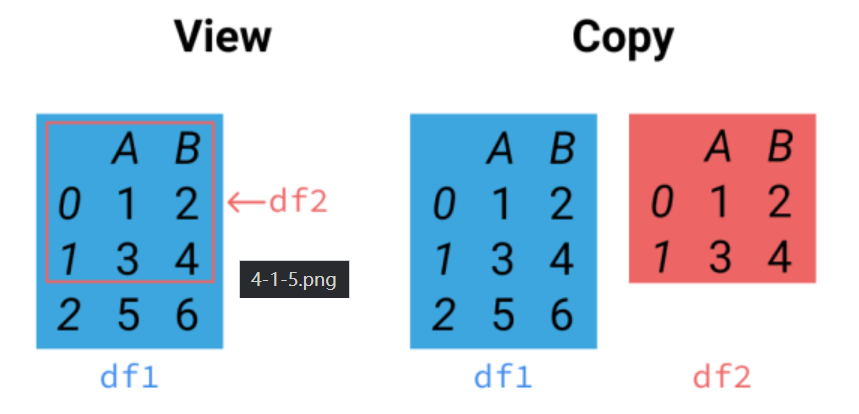


In [1]:
import numpy as np

a = np.arange(1, 7).reshape((3,2))
a_view = a[:2]
a_copy = a[:2].copy()

a_copy[1,1] = 0
print("在 copy 上修改数据，不会影响源数据：\n", a)

a_view[1,1] = 0
print("在 view 上修改数据，会影响'窗里'的源数据：\n", a)

在 copy 上修改数据，不会影响源数据：
 [[1 2]
 [3 4]
 [5 6]]
在 view 上修改数据，会影响'窗里'的源数据：
 [[1 2]
 [3 0]
 [5 6]]


View 只是加了窗，不会复制东西, 速度快! 

In [2]:
import timeit
from functools import partial
        
def get_run_time(func, *args):
    repeat = 3
    number = 200
    return min(timeit.Timer(partial(func, *args)).repeat(repeat=repeat, number=number)) / number

In [3]:
a = np.random.rand(1000, 1000)
b = np.random.rand(1000, 1000)

def f1():
    global b
    # 这会产生新的 b
    b = 2*b

def f2():
    global a
    # 这不会产生新的 a
    a *= 2    # 和 a[:] *= 2 一样

print('%.6f - b = 2*b' % get_run_time(f1))     
print('%.6f - a *= 2' % get_run_time(f2)) 

0.003291 - b = 2*b
0.000777 - a *= 2


上面的例子中 a*=2 就是将这个 view 给赋值了, 和 a[:] *= 2 一个意思, 从头到尾没有创建新的东西。而 b = 2*b 中, 我们将 b 赋值给另外一个新建的 b   

对于 view 还有一点要提, 你是不是偶尔有时候要把一个矩阵展平, 用到 np.flatten() 或者 np.ravel()。 我们在改变数据结构 中也提到了这两个功能。 他俩虽然结果上相同，但是含义是完全不同的! 官方说如果用 ravel(), 需要 copy 的时候才会被 copy , 我想这个时候可能是把 ravel 里面 order 转换的时候, 如 'C-type' -> 'Fortran', 而 flatten() 返回的总是一个 copy。现在你知道谁在拖你的后腿了吧!

In [4]:
def f1():
    a.flatten()

def f2():
    b.ravel()

print('%.6f - flatten' % get_run_time(f1))     
print('%.6f - ravel' % get_run_time(f2)) 

0.002865 - flatten
0.000000 - ravel


相比于 flatten(), ravel() 简直是神速
# 在选择数据上加速
常会用到 view 或者 copy 的形式。现在你应该知道了, 如果能用到 view 的, 我们就尽量用 view, 避免 copy 数据。那在选择数据的时候，那些是选择了一个 view 呢? 下面举例的都是 view 的方式:

In [5]:
a = np.zeros([100, 100])
a_view1 = a[1:2, 3:6]    # 切片 slice
a_view2 = a[:100]        # 同上
a_view3 = a[::2]         # 跳步
a_view4 = a.ravel()      # 上面提到了

那哪些操作我们又会变成 copy 呢

In [6]:
a = np.zeros([2, 2])
a_copy2 = a[[True, True], [False, True]]  # 用 mask

a = np.zeros([100, 100])
a_copy1 = a[[1,4,6], [2,4,6]]   # 用 index 选
a_copy3 = a[[1,2], :]        # 虽然 1,2 的确连在一起了, 但是他们确实是 copy
a_copy4 = a[a[1,:] != 0, :]  # fancy indexing
a_copy5 = a[np.isnan(a[:,0]), :]  # fancy indexing

## 使用 np.take(), 替代用 index 选数据的方法。

In [7]:
a = np.random.rand(1000000, 10)
indices = np.random.randint(0, len(a), size=10000)

def f1():
    # fancy indexing
    _ = a[indices]

def f2():
    # take
    _ = np.take(a, indices, axis=0)

print('%.6f - [indices]' % get_run_time(f1))     
print('%.6f - take' % get_run_time(f2)) 

0.000327 - [indices]
0.000147 - take


## 使用 np.compress(), 替代用 mask 选数据的方法。

In [8]:
a = np.random.rand(10000, 10)
mask = a[:, 0] < 0.5

def f1():
    _ = a[mask]

def f2():
    _ = np.compress(mask, a, axis=0)
        

print('%.6f - [mask]' % get_run_time(f1))     
print('%.6f - compress' % get_run_time(f2))

0.000142 - [mask]
0.000078 - compress


# 非常有用的 out 参数
比如下面两个其实在功能上是没差的, 不过运算时间上有差, 我觉得可能是 a=a+1 要先转换成 np.add() 这种形式再运算, 所以前者要用更久一点的时间.

In [9]:
a = np.zeros([10000, 10])

def f1(a):
    a = a + 1 

def f2(a):
    a = np.add(a, 1)
        

print('%.6f - a + 1' % get_run_time(f1, a))     
print('%.6f - np.add(a, 1)' % get_run_time(f2, a))

0.000036 - a + 1
0.000044 - np.add(a, 1)


我们看看使用 out 之前，它们的处理方式算不算 copy。

In [10]:
a = np.zeros([2,])
a_copy = np.add(a, 1)  # copy 发生在这里
print(a, a_copy)

b = np.zeros([2,])
c = np.zeros_like(b)  # copy 发生在这里
np.add(b, 1, out=c)
print(b, c)

[0. 0.] [1. 1.]
[0. 0.] [1. 1.]


如果我们新建了一个 c，用 out=c 来指定将加法结果输出到 c

In [11]:
a = np.zeros([1000, 1000])
b = np.zeros_like(a)
c = np.zeros_like(a)

def f1():
    a[:] = np.add(a, 1)  # 把计算结果赋值回原数据

def f2():
    np.add(b, 1, out=b)  # 把计算结果赋值回原数据

def f3():
    _c = np.add(c, 1)   # 把计算结果赋值到新数据


print('%.6f - without out' % get_run_time(f1))     
print('%.6f - out' % get_run_time(f2))
print('%.6f - new data' % get_run_time(f3))

0.004389 - without out
0.000725 - out
0.003047 - new data
